## Непараметрическая оценка плотности

In [12]:
%matplotlib inline

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

In [14]:
import numpy as np
import pandas as pd
from scipy import stats, integrate

In [15]:
data = pd.read_csv('euro_weights', sep='\t', header=None,index_col=0, names=['weight', 'group'])

Все непараметрические оценки плотности основаны на следующей идее:
$$p(x) \approx \frac{k}{nV}$$,
где $V$ - объем региона вокруг $x$, $n$ - общее число точек, $k$ - число точек, попавших в регион вокруг.

### Простейшая непараметрическая оценка плотности - гистограмма

Как мы с вами знаем, гистограмма делит област значений рассматриваемого признака на $k$ интервалов, и для оценки плотности использует следующее правило: $n_k/n.$

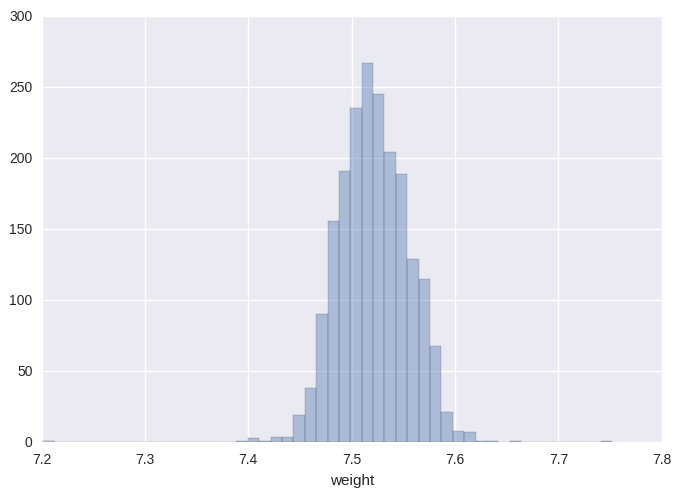

In [16]:
sns.distplot(data['weight'], kde=False)

Для выбора числа интервалов $k$ используются различные правила:
* $k = \sqrt{n};$
* $k = log_2 \, n +1$ - правило Стерджеса;
* $k = 2n^{1/3}$ - правило Райса;
* $ h = \frac{3.5\hat{sigma}}{n^3},$ $k = \frac{x_{max} - x_{min}}{h}$- правило Скотта.

### Окно Парзена

Для каждой точки из выборки строим гиперкуб с ребром $h$ и проверяем все точки на попадание в него:

$$ K(u) = \cases{1, \lvert u_j \rvert < 1/2; 
                \\ 0.}$$

$$ u = \frac{x_i - x}{h}.$$

Оценка плотности будет иметь вид:
$$p(x) = \frac{1}{nh^D}\sum_{i=1}^{n} K(\frac{x_i-x}{h}).$$

По сути, это та же гистограмма, только интервала шириной $h$ выбираются в точках, соответствующим реальным наблюдениям. На практике им сейчас пользуются редко, так как окно Парзена равнозначно взвешивает все точки внутри квадрата, а также прерывно. Обычно для того, чтобы этого избежать используют другие, т.н. гладкие ядерные функции.

### Гауссово ядро

Оценка плотности имеет вид:

$$ p(x) = \frac{1}{n} \sum_{i=1}^{n} \frac{1}{\sqrt{2\pi}} exp\left( -\frac{(x_i-x)^2}{h} \right).$$

Параметр $\sigma$  должен быть определен заранее.

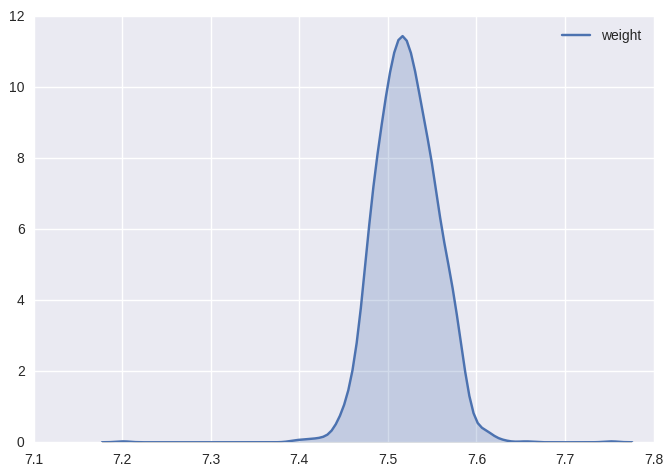

In [17]:
sns.kdeplot(data['weight'], shade=True)

Иллюстрация расчета приведена ниже:

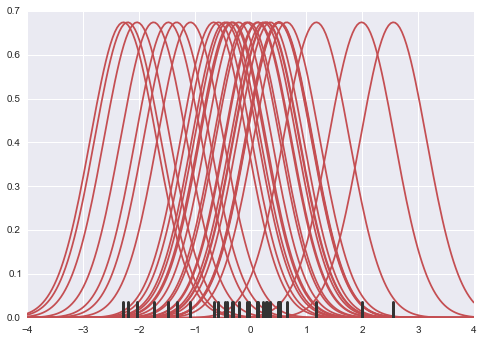

In [7]:
x = np.random.normal(0, 1, size=30)
bandwidth = 1.06 * x.std() * x.size ** (-1 / 5.)
support = np.linspace(-4, 4, 200)

kernels = []
for x_i in x:

    kernel = stats.norm(x_i, bandwidth).pdf(support)
    kernels.append(kernel)
    plt.plot(support, kernel, color="r")

sns.rugplot(x, color=".2", linewidth=3);

### Ядро Епанечникова

Является наиболее эффективным ядром для оценки плотности:
$$ K(u) = \frac{3}{4} (1-u^2) I[u \leq 1], $$
$$ p(x) = \sum_{i=1}^{n} K(\frac{x_i - x}{h}).$$

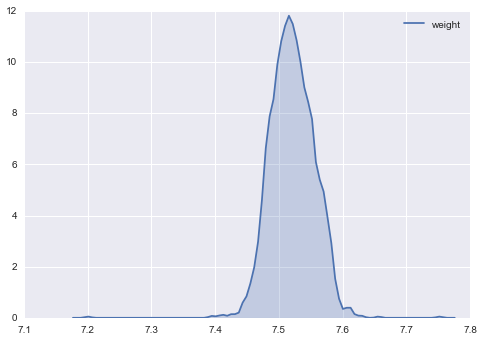

In [8]:
sns.kdeplot(data['weight'], shade=True, kernel='epa')

Распостраненные примеры ядерных функций можно найти в Вики:

https://en.wikipedia.org/wiki/Kernel_(statistics)#Kernel_functions_in_common_use

### Выбор параметра h:

Вариантов несколько:
* оптимизация $h$ под наблюдаемые данные или с помощью кросс-валидации;
* нахождение оптимального с точки зрения минимизации ошибки значения с помощью теоретического ЗР;
* **эмпирические правила**, в частности, правило Сильверманна: 
$$ h = \left( \frac{4\hat{\sigma}^5}{3n}\right)^{1/5} \approx 1.06\hat{\sigma}n^{-1/5}.$$

In [9]:
from mpl_toolkits.basemap import Basemap

In [21]:
df = pd.read_csv("Allstorms.ibtracs_wmo.v03r05.csv")

In [22]:
df[df.columns[[0,1,3,8,9]]].head()

,Serial_Num,Season,Basin,Latitude,Longitude
0,1848011S09080,1848,SI,-8.6,79.8
1,1848011S09080,1848,SI,-9.0,78.9
2,1848011S09080,1848,SI,-10.4,73.2
3,1848011S09080,1848,SI,-12.8,69.9
4,1848011S09080,1848,SI,-13.9,68.9


Сгруппируем места возникновения штормов по координатам.

In [23]:
dfs = df.groupby('Serial_Num')
pos = dfs[['Latitude', 'Longitude']].mean()
y, x = pos.values.T
pos.head()

,Latitude,Longitude
Serial_Num,,
1848011S09080,-15.918182,71.854545
1848011S15057,-24.116667,52.016667
1848061S12075,-20.528571,65.342857
1851080S15063,-17.325000,55.400000
1851080S21060,-23.633333,60.200000


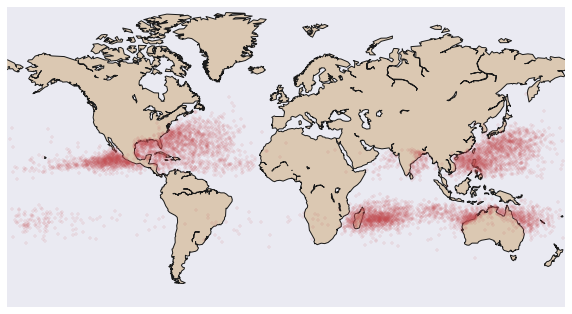

In [25]:
m = Basemap(projection='mill', llcrnrlat=-65 ,urcrnrlat=85,
            llcrnrlon=-180, urcrnrlon=180)
x0, y0 = m(-180, -65)
x1, y1 = m(180, 85)
plt.figure(figsize=(10,6))
m.drawcoastlines()
m.fillcontinents(color='#dbc8b2')
xm, ym = m(x, y)
m.plot(xm, ym, '.r', alpha=.1);


Сгрупируем данные, чтобы получить для каждого наблюдения пару $(long_i, lat_i).$

In [27]:
h = np.vstack((xm, ym))
kde = stats.gaussian_kde(h)

Теперь представим карту в виде двумерной плоскости, в каждой точке которой мы оценим плотность.

In [28]:
k = 50
tx, ty = np.meshgrid(np.linspace(x0, x1, 2*k),
                     np.linspace(y0, y1, k))
v = kde(np.vstack((tx.ravel(), ty.ravel()))).reshape((k, 2*k))

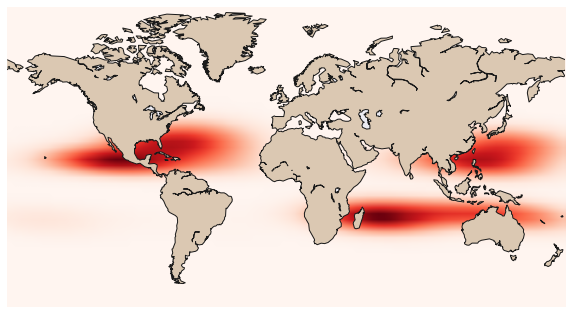

In [30]:
plt.figure(figsize=(10,6))
m.drawcoastlines()
m.fillcontinents(color='#dbc8b2')
xm, ym = m(x, y)
m.imshow(v, origin='lower', extent=[x0,x1,y0,y1],
         cmap=plt.get_cmap('Reds'));